In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
import re
file_path = '/content/instagram_profiles.csv'
info = pd.read_csv(file_path)

profile_info_column = 'Information'

def extract_numbers(info):

    match = re.match(r"([\d,]+) posts \| ([\d.,MK]+) followers \| ([\d,]+) following", info)
    if match:
        posts = int(match.group(1).replace(",", ""))
        followers = match.group(2)
        following = int(match.group(3).replace(",", ""))

        if 'M' in followers:
            followers = int(float(followers.replace("M", "")) * 1_000_000)
        elif 'K' in followers:
            followers = int(float(followers.replace("K", "")) * 1_000)
        else:
            followers = int(followers.replace(",", ""))

        return posts, followers, following
    else:
        return None, None, None

info[['posts', 'followers', 'following']] = info[profile_info_column].apply(
    lambda x: pd.Series(extract_numbers(x))
)
print(info[['posts', 'followers', 'following']].head())



   posts  followers  following
0   8651    8000000        307


In [4]:
with open('/content/instagram_profile_simeonpanda.json', 'r') as file:
    data = json.load(file)


In [7]:
posts = data['posts']
posts_data = []
posts

{'post_1': {'post_url': 'https://www.instagram.com/simeonpanda/p/CszIM2jP9z-/',
  'likes': '76,481',
  'hashtags': [],
  'location': 'Locations',
  'post_date': '2023-05-28T19:39:44.000Z',
  'comments': [{'username': 'jmovieman',
    'comment': 'From Hithergreen to the WORLD!! Love this 🙌🏾'},
   {'username': 'fat2fitdiary2017',
    'comment': 'You paid it off because the interest rates are high and it was costing too much. Who you kidding with this fake story about putting your family at peace .'},
   {'username': 'biggrey_', 'comment': 'Congratulations 🙌'},
   {'username': 'serge_vieira', 'comment': '👏🏾🔥'},
   {'username': 'stevee760',
    'comment': "Hell, hell bro, that's what it's all about taking care of your family. I'm almost there Its taken me 11 years, but as long as my kids have a roof over their heads, that's all that matters."},
   {'username': 'ricky611_solomon',
    'comment': 'Wow! That’s truly a blessing @simeonpanda! More blessings in life and family! 🙏❤️💪😎🏋🏼\u200d♀️💯🏃

In [10]:
for post_key, post in posts.items():
    try:
        # Convert likes to an integer, handle non-numeric cases
        likes = int(post['likes'].replace(',', '')) if post['likes'].replace(',', '').isdigit() else 0

        post_data = {
            'post_url': post['post_url'],
            'likes': likes,
            'hashtags': len(post['hashtags']) if post['hashtags'] else 0,
            'location': post['location'] if post['location'] else 'Unknown',
            'post_date': pd.to_datetime(post['post_date'], errors='coerce'),  # Convert date or set to NaT
            'comments_count': len(post['comments']) if post['comments'] else 0,  # Handle missing comments
        }
        posts_data.append(post_data)
    except KeyError as e:
        print(f"KeyError: Missing key {e} in post {post_key}")
    except Exception as e:
        print(f"Error processing post {post_key}: {e}")

In [17]:
df = pd.DataFrame(posts_data)
print(df.head)

<bound method NDFrame.head of                                               post_url  likes  hashtags  \
0    https://www.instagram.com/simeonpanda/p/CszIM2...  76481         0   
1    https://www.instagram.com/simeonpanda/p/CsL7eR...  21703         0   
2    https://www.instagram.com/simeonpanda/p/C5067z...   6526         0   
3    https://www.instagram.com/simeonpanda/p/Cx8FRq...  41303         0   
4    https://www.instagram.com/simeonpanda/p/CpR3Mj...  10895         0   
..                                                 ...    ...       ...   
415  https://www.instagram.com/simeonpanda/p/C3hQ53...  18495         1   
416  https://www.instagram.com/simeonpanda/p/C_QtvJ...  17884         5   
417  https://www.instagram.com/simeonpanda/p/C1Hx2M...   6549         0   
418  https://www.instagram.com/simeonpanda/p/CtmJ3n...  17013         0   
419  https://www.instagram.com/simeonpanda/p/C-QLl0...   4092         3   

                    location                 post_date  comments_coun

In [18]:
df.columns

Index(['post_url', 'likes', 'hashtags', 'location', 'post_date',
       'comments_count'],
      dtype='object')

In [19]:
df.set_index('post_date', inplace=True)
sns.set(style="whitegrid")

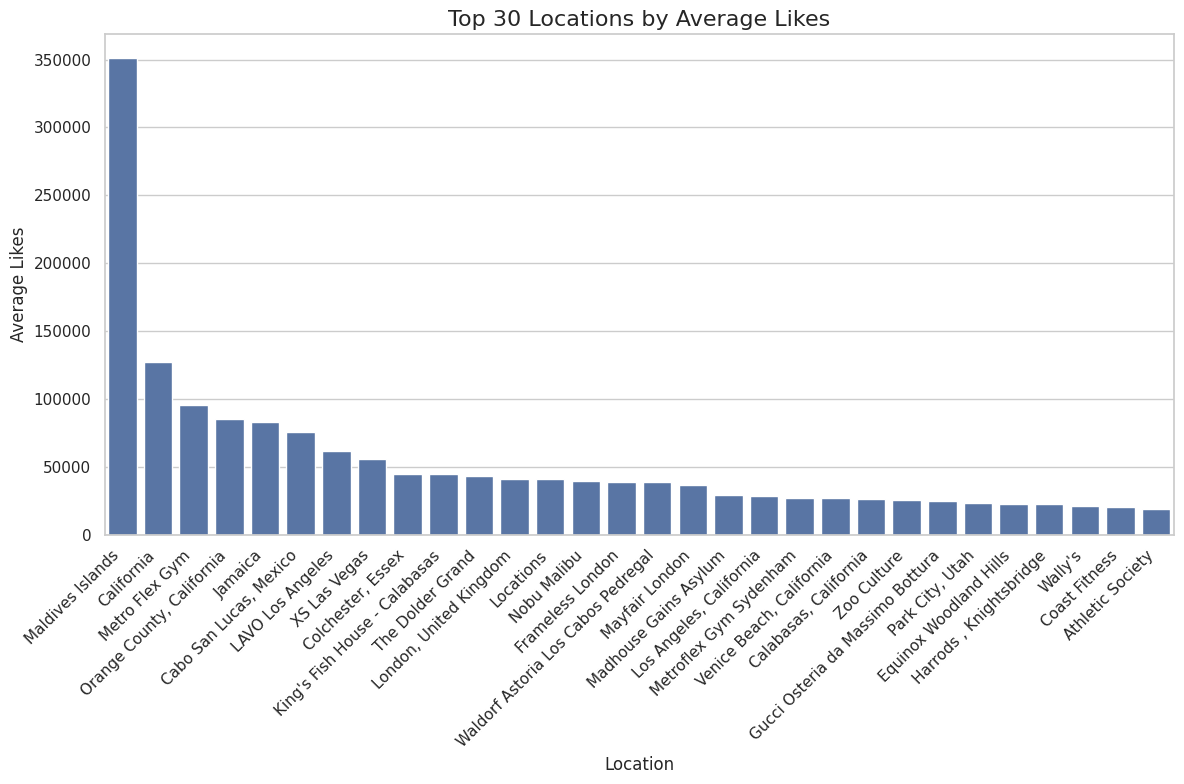

In [21]:
# Compute average likes by location
average_likes_by_location = (
    df.groupby('location')['likes']
    .mean()
    .reset_index()
    .sort_values(by='likes', ascending=False)
    .head(30)  # Select top 30 locations
)

# Bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='location',
    y='likes',
    data=average_likes_by_location,
    estimator='mean',
    errorbar=None
)
plt.title('Top 30 Locations by Average Likes', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Average Likes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


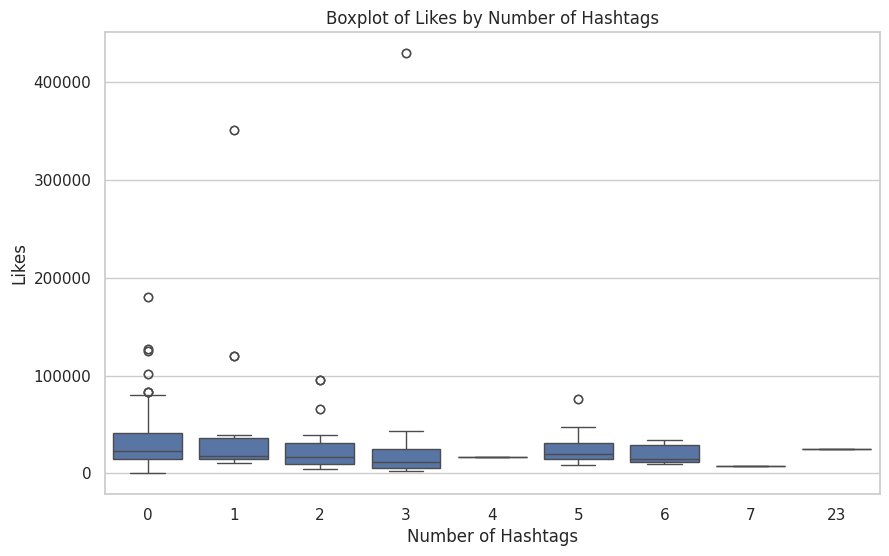

In [22]:
#Boxplot of Likes by Hashtags Count
plt.figure(figsize=(10, 6))
sns.boxplot(x='hashtags', y='likes', data=df.reset_index())
plt.title('Boxplot of Likes by Number of Hashtags')
plt.xlabel('Number of Hashtags')
plt.ylabel('Likes')
plt.show()

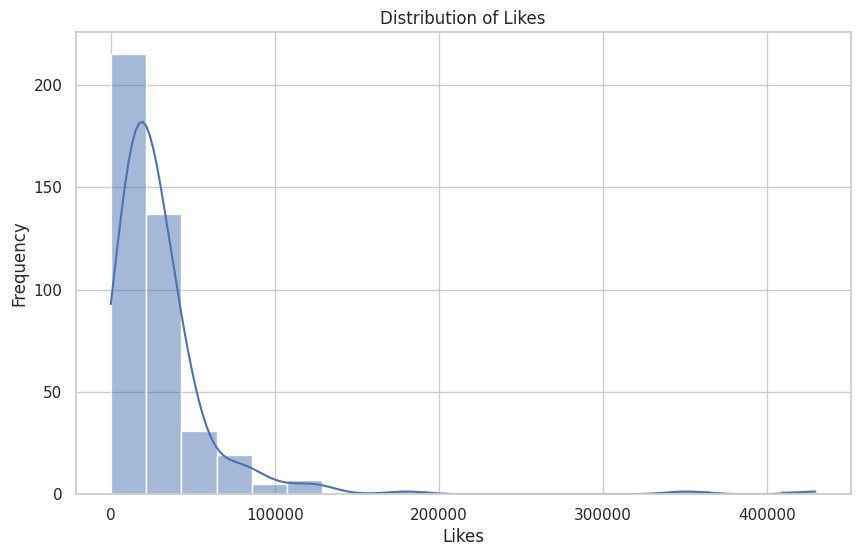

In [23]:
#Histogram of Likes Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['likes'], bins=20, kde=True)
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.show()

<ipython-input-24-709a57caa78e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_likes = df['likes'].resample('M').mean()  # Resampling to monthly frequency


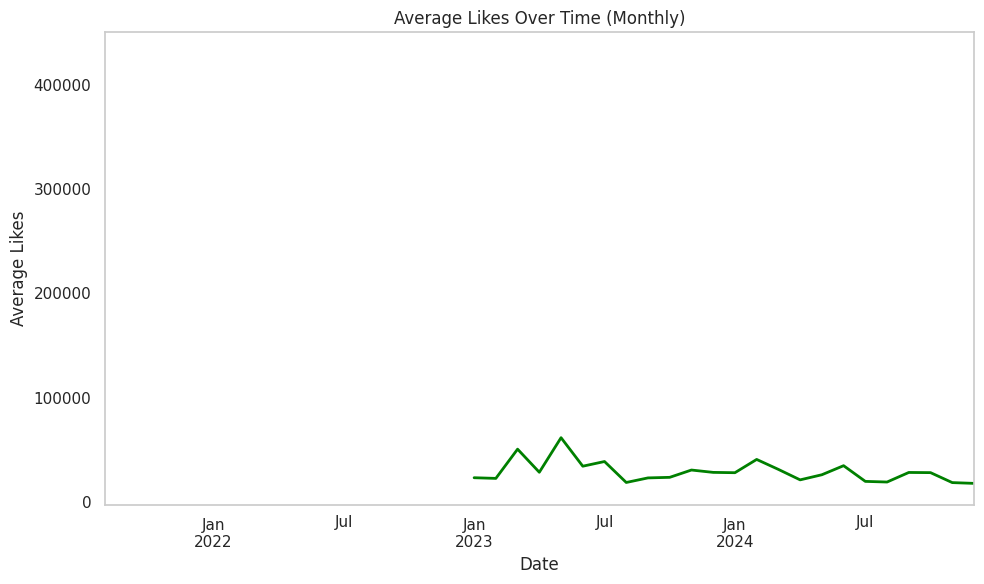

In [24]:
#Likes Over Time (Monthly Average)
plt.figure(figsize=(10, 6))
monthly_likes = df['likes'].resample('M').mean()  # Resampling to monthly frequency
monthly_likes.plot(color='green', linestyle='-', linewidth=2)
plt.title('Average Likes Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Average Likes')
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In [30]:
from collections import Counter
all_hashtags = []
for post in data['posts'].values():
    all_hashtags.extend(post['hashtags'])
print(all_hashtags)

['#sonmontuno', '#LeanerByTheDay', '#hdmuscless', '#abs', '#fitness', '#gym', '#workout', '#fitnessmotivation', '#motivation', '#fit', '#bodybuilding', '#training', '#health', '#lifestyle', '#fitfam', '#healthylifestyle', '#sport', '#healthy', '#gymlife', '#life', '#crossfit', '#personaltrainer', '#goals', '#exercise', '#muscle', '#innosupps', '#thermoshredstck', '#simeonpanda', '#ad', '#innosupps', '#thermoshredstck', '#simeonpanda', '#bodybuilding', '#naturalbodybuilding', '#ad', '#sponsored', '#innosupps', '#legday', '#bodybuilding', '#naturalbodybuilding', '#lats', '#ad', '#innosupps', '#quads', '#quadworkout', '#workoutvideo', '#gymworkout', '#workoutideas', '#legday', '#squats', '#bodybuilding', '#naturalbodybuilding', '#chest', '#chestworkout', '#workoutvideo', '#gymworkout', '#workoutideas', '#simeonpanda', '#innosupps', '#innoshred', '#fatburn', '#fatburner', '#quads', '#quadworkout', '#workoutvideo', '#gymworkout', '#workoutideas', '#timeflies', '#beautiful', '#fatherson', '#

In [31]:
len(all_hashtags)

294

In [32]:
top_n = 10
hashtag_counts = Counter(all_hashtags)
top_hashtags = hashtag_counts.most_common(top_n)
print(top_hashtags)

[('#workoutvideo', 29), ('#gymworkout', 29), ('#workoutideas', 29), ('#innosupps', 18), ('#ad', 16), ('#bodybuilding', 10), ('#naturalbodybuilding', 8), ('#quads', 8), ('#quadworkout', 7), ('#simeonpanda', 6)]


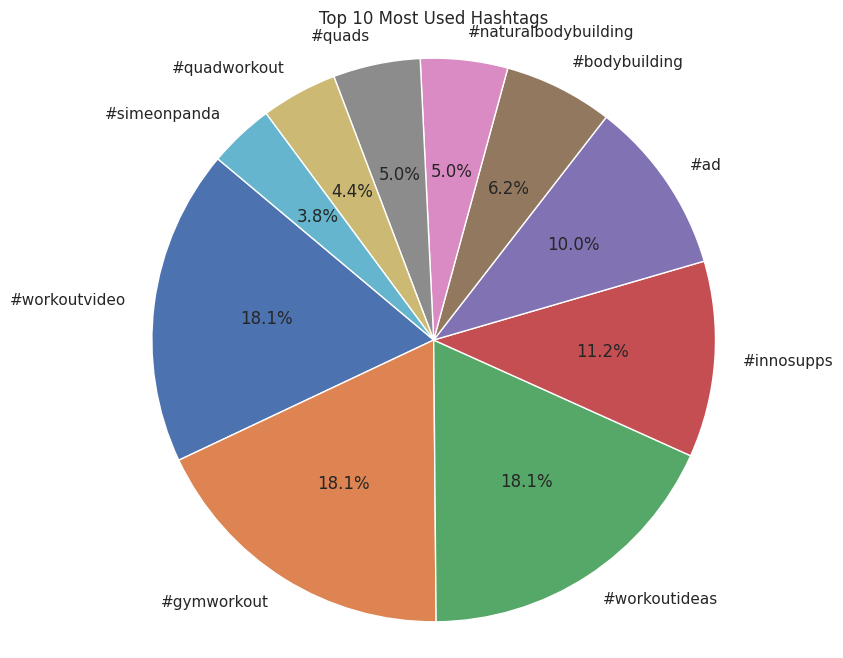

In [33]:
labels, counts = zip(*top_hashtags)

# Plot a pie chart of the most used hashtags
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Top {top_n} Most Used Hashtags')
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular
plt.show()

In [34]:
comments_per_post = []
unique_commenters_per_post = []
all_commenters = []

# Extract comments data and perform calculations
for post_key, post in data['posts'].items():
    # List of usernames who commented on this post
    commenters = [comment['username'] for comment in post['comments']]
    comments_per_post.append(len(commenters))  # Count of comments for each post
    unique_commenters_per_post.append(len(set(commenters)))  # Count of unique commenters
    all_commenters.extend(commenters)  # Accumulate all commenters across posts for analysis

# Count most active users
top_n = 10
active_users = Counter(all_commenters).most_common(top_n)
active_usernames, active_user_counts = zip(*active_users)  # Separate names and counts

In [35]:
print(f"Top {top_n} Most Active Users: {active_usernames}")
print(f"Count of Top {top_n} Most Active Users: {active_user_counts}")

Top 10 Most Active Users: ('photisdimitroukas', 'molinasdios15', 'zung_le_', 'soccerguyunited', 'louty.camara', 'sean_cameron_bean', 'yavvasggshh', 'vic18albert', 'nitdofflala', 'libsimeon')
Count of Top 10 Most Active Users: (33, 28, 27, 27, 26, 25, 15, 14, 14, 12)


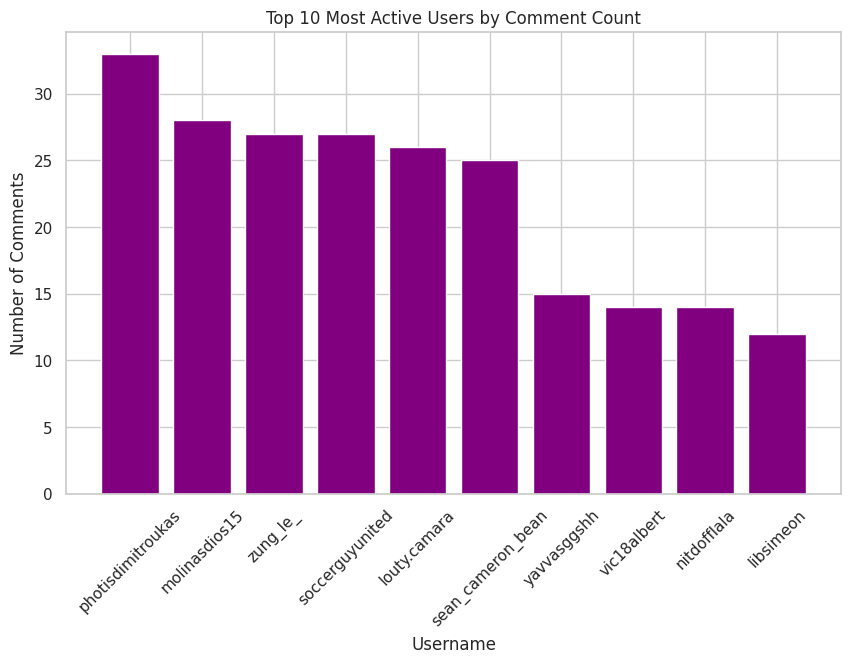

In [36]:
#Bar Chart of Most Active Users
plt.figure(figsize=(10, 6))
plt.bar(active_usernames, active_user_counts, color='purple')
plt.xlabel("Username")
plt.ylabel("Number of Comments")
plt.title("Top 10 Most Active Users by Comment Count")
plt.xticks(rotation=45)
plt.show()


In [37]:
# Placeholder average likes for example calculation (update if available)
average_likes_per_post = df.loc[:, 'likes'].mean() # Replace with actual data if known

# 1. Engagement Rate Calculation
engagement_rate = (average_likes_per_post / info['followers'][0]) * 100
print("Engagement Rate:", engagement_rate, "%")

# 2. Average Comments per Post
average_comments_per_post = df['comments_count'].mean()
print("Average Comments per Post:", average_comments_per_post)

# 3. Average Hashtags per Post
average_hashtags_per_post = df['hashtags'].mean()
print("Average Hashtags per Post:", average_hashtags_per_post)


Engagement Rate: 0.39506285714285716 %
Average Comments per Post: 13.89047619047619
Average Hashtags per Post: 1.4880952380952381


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [39]:
# Feature Engineering
df['weekday'] = df.index.dayofweek  # Day of the week as a feature
df['month'] = df.index.month  # Month as a feature
df['hour'] = df.index.hour  # Hour of posting as a feature (if datetime includes time)

# Convert categorical features to dummy variables (e.g., location)
df = pd.get_dummies(df, columns=['location'], drop_first=True)

# Prepare target variable and feature set
X = df.drop(['post_url', 'likes'], axis=1)
y = df['likes']

In [40]:
print(X)

                           hashtags  comments_count  weekday  month  hour  \
post_date                                                                   
2023-05-28 19:39:44+00:00         0              12      6.0    5.0  19.0   
2023-05-13 14:18:08+00:00         0              12      5.0    5.0  14.0   
2024-04-16 15:10:25+00:00         0              14      1.0    4.0  15.0   
2023-10-03 13:44:19+00:00         0              11      1.0   10.0  13.0   
2023-03-02 08:04:15+00:00         0              14      3.0    3.0   8.0   
...                             ...             ...      ...    ...   ...   
2024-02-19 06:54:48+00:00         1              13      0.0    2.0   6.0   
2024-08-29 16:50:48+00:00         5              15      3.0    8.0  16.0   
2023-12-21 16:19:37+00:00         0              15      3.0   12.0  16.0   
2023-06-17 15:15:35+00:00         0              13      5.0    6.0  15.0   
2024-08-04 15:21:02+00:00         3              15      6.0    8.0  15.0   

In [41]:
print(y)

post_date
2023-05-28 19:39:44+00:00    76481
2023-05-13 14:18:08+00:00    21703
2024-04-16 15:10:25+00:00     6526
2023-10-03 13:44:19+00:00    41303
2023-03-02 08:04:15+00:00    10895
                             ...  
2024-02-19 06:54:48+00:00    18495
2024-08-29 16:50:48+00:00    17884
2023-12-21 16:19:37+00:00     6549
2023-06-17 15:15:35+00:00    17013
2024-08-04 15:21:02+00:00     4092
Name: likes, Length: 420, dtype: int64


In [50]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Use mean imputation
X_imputed = imputer.fit_transform(X)

In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [56]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [57]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

In [58]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r2
    }

In [59]:
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Mean Squared Error: {metrics['MSE']}")
    print(f"  Mean Absolute Error: {metrics['MAE']}")
    print(f"  R-squared: {metrics['R-squared']}\n")

Linear Regression:
  Mean Squared Error: 3187896878.060033
  Mean Absolute Error: 22727.5825053962
  R-squared: -0.001103846051251578

Ridge Regression:
  Mean Squared Error: 3179061625.416677
  Mean Absolute Error: 22696.850386972783
  R-squared: 0.0016707121419484716

Lasso Regression:
  Mean Squared Error: 3187352542.442373
  Mean Absolute Error: 22726.031707360682
  R-squared: -0.0009329068705858923

Elastic Net:
  Mean Squared Error: 3121113325.5521555
  Mean Absolute Error: 23130.267237593915
  R-squared: 0.019868372883661722

Random Forest:
  Mean Squared Error: 2774455518.7665424
  Mean Absolute Error: 16397.700496031746
  R-squared: 0.1287302579795051

XGBoost:
  Mean Squared Error: 2777880576.0
  Mean Absolute Error: 11820.6630859375
  R-squared: 0.12765473127365112



In [62]:
# Plot actual vs. predicted values for the best model (e.g., Random Forest)
best_model_name = 'Ridge Regression'  # Adjust this to the best performing model based on the metrics
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

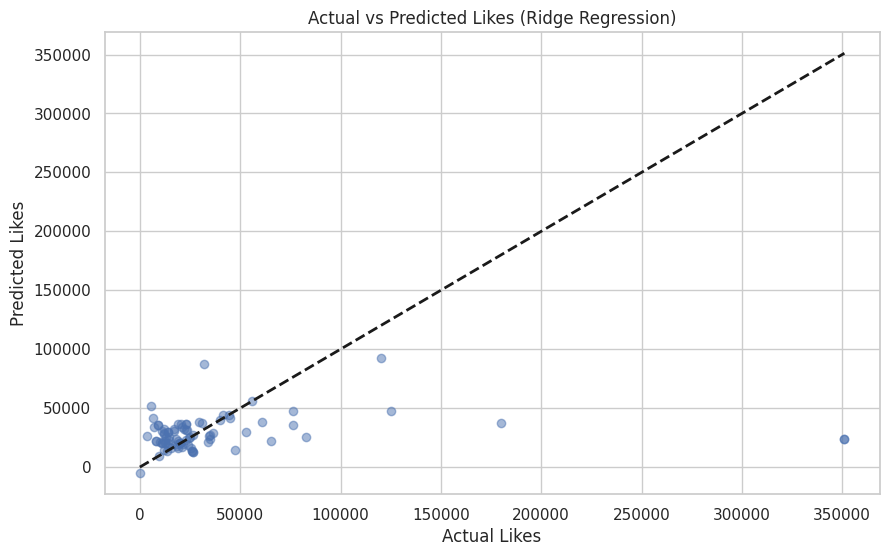

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title(f'Actual vs Predicted Likes ({best_model_name})')
plt.show()

In [77]:
import json

# Function to calculate total likes for a given hashtag
def calculate_likes_for_hashtag(json_file_path, hashtag):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    total_likes = 0

    # Iterate through posts
    for post_id, post_data in data['posts'].items():
        hashtags = post_data.get('hashtags', [])

        # Check if the hashtag is present in the post
        if hashtag in hashtags:
            likes_str = post_data.get('likes', "0").replace(",", "")  # Remove commas
            if likes_str.isdigit():  # Ensure likes is a valid number
                total_likes += int(likes_str)

    return total_likes

# File path to the JSON file
json_file_path = 'instagram_profile_simeonpanda.json'
hashtag_word = input("Enter the word for the hashtag: ").strip()
hashtag_to_search = f"#{hashtag_word}"  # Add # to the word

# Calculate total likes
total_likes = calculate_likes_for_hashtag(json_file_path, hashtag_to_search)
print(f"Total likes for '{hashtag_to_search}': {total_likes}")


Enter the word for the hashtag: gym
Total likes for '#gym': 25201
